# Call Option Pricing with Black-Scholes-Merton, Newton-Raphson Method, Euler Discretization and Brownian Motion.

In [1]:
import numpy as np
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as si
from sklearn import preprocessing
from scipy import stats
import statsmodels.api as sm
%matplotlib inline
from scipy.stats import norm
from math import *
from pandas import DataFrame

### Black-Scholes

In [2]:
ticker = 'PG' 
data = pd.DataFrame()
data[ticker] = wb.DataReader(ticker, data_source='yahoo', start='2007-1-1')['Adj Close']

In [3]:
#.pct change = percentage change
log_returns = np.log(1 + data.pct_change())
log_returns.tail()

,PG
Date,
2021-02-12,-0.005548
2021-02-16,0.002348
2021-02-17,0.004213
2021-02-18,0.008295
2021-02-19,-0.007906


$$
d_1 = \frac{\ln(\frac{S}{K}) + (r + \frac{stdev^2}{2})t}{s \cdot \sqrt{t}}
$$

$$
d_2 = d_1 - s \cdot \sqrt{t} = \frac{\ln(\frac{S}{K}) + (r - \frac{stdev^2}{2})t}{s \cdot \sqrt{t}}
$$

In [4]:
# It calculates the value of a call by taking the difference between the amount you get
# if you exercise the option minus the amount you have to pay if you exercise the option
# d1 = How much can we expect if option is exercised
# or d1 = Multipling probability of exercising the options by the amount received when the option is exercised
# d2 = discounted value of The amount we must pay when exercising the option
# All following a noraml distribution following 
# S = Current stock price / K= Option stock price / t= time until option expires / r = risk - free interest rate
# N = Standard Normal Distribution / e = exponetial term / C = call value / s=sample standard deviation 
# stdev2 or sigma = volatility of underlying asset / C1 = Call premium

In [5]:
def call_bsm(S, K, r, stdev, T,Otype):
    d1 = (np.log(S / K) + (r + stdev ** 2 / 2) * T) / (stdev * (np.sqrt(T)))
    d2 = (np.log(S / K) + (r - stdev ** 2 / 2) * T) / (stdev * (np.sqrt(T)))
    if (Otype == "Call"):
        price = S*(si.norm.cdf(np.float(d1))) \
        - K*(np.exp(-r*T))*(si.norm.cdf(np.float(d2)))
        return (price)
    elif (Otype == "Put"):
        price  = -S*(si.norm.cdf(np.float(-d1)))\
        + K*(np.exp(-r*T))*(si.norm.cdf(np.float(-d2)))
        return (price)

In [6]:
#Separated Formula
def BSM(S, K, r, stdev, T):
        return (S * norm.cdf(d1(S, K, r, stdev, T))) - (K * np.exp(-r * T) * norm.cdf(d2(S, K, r, stdev, T)))

$$
\textbf{C} = SN(d_1) - Ke^{-rt}N(d_2) 
$$

In [7]:
def d1_f(S, K, r, stdev, T):
    return (np.log(S / K) + (r + stdev ** 2 / 2) * T) / (stdev * np.sqrt(T))
 
def d2_f(S, K, r, stdev, T):
    return (np.log(S / K) + (r - stdev ** 2 / 2) * T) / (stdev * np.sqrt(T))
S = data.iloc[-1]
stdev = log_returns.std() * 250 ** 0.5

In [48]:
S = data.iloc[-1]
log_returns = np.log(1 + data.pct_change())
stdev = log_returns.std() * 250 ** 0.5
Otype = ('Call')
r = 0.025
K = 110.0
T = 1
d1 = d1_f(S, K, r, stdev, T)
d2 = d2_f(S, K, r, stdev, T)
S0 = si.norm.cdf(d1, 0.0, 1.0)
C = call_bsm(S, K, r, stdev, T,Otype)
print(S, stdev, C)


PG    81.227325
Name: 2017-03-21 00:00:00, dtype: float64 PG    0.17655
dtype: float64 PG    0.404182
Name: 2017-03-21 00:00:00, dtype: float64


array([0.06842244])

In [59]:
S

PG    81.227325
Name: 2017-03-21 00:00:00, dtype: float64

### Implementation of Vega/Delta/Gamma/Theta/Rho for Non-Dividend Paying Assets

In [9]:
T_sqrt = sqrt(T)
d1 = (log(float(S)/K)+((r)+stdev*stdev/2.)*T)/(stdev*T_sqrt)
d2 = d1-stdev*T_sqrt
Delta = norm.cdf(d1)
Gamma = norm.pdf(d1)/(S*stdev*T_sqrt)
Theta =- (S*stdev*norm.pdf(d1))/(2*T_sqrt) - r*K*exp( -r*T)*norm.cdf(d2)
Vega = S * T_sqrt*norm.pdf(d1)
Rho = K*T*exp(-r*T)*norm.cdf(d2)
greek = [Delta,Gamma,Theta,Vega,Rho]
print('Delta:'+ str(Delta),'Gamma:'+str(Gamma),'Theta:'+str(Theta),'Vega:'+str(Vega),'Rho:'+str(Rho))

Delta:[0.94112418] Gamma:PG    0.004869
dtype: float64 Theta:PG   -3.647384
dtype: float64 Vega:PG    15.083192
Name: 2021-02-19 00:00:00, dtype: float64 Rho:[89.30887541]


### Newton's Method for Nonlinear Equations, vega  implied volatility - No dividends

In [56]:
def newton_vol_call(S, K, T, C, r, stdev):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #C: Call value
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r - 0.5 * stdev ** 2) * T) / (stdev * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * stdev ** 2) * T) / (stdev * np.sqrt(T))
    
    fx = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0) - C
    vega = (1 / np.sqrt(2 * np.pi)) * S * np.sqrt(T) * np.exp(-(si.norm.cdf(d1, 0.0, 1.0) ** 2) * 0.5)
    
    
    
    tolerance = 0.000001
    x0 = stdev
    xnew  = x0
    xold = x0 - 1
        
    while (abs(xnew - xold) > tolerance):
    
        xold = xnew 
        xnew = (xnew - fx - C) / vega
        
        return abs(xnew)

In [58]:
newton_vol_call(25, 20, 1, 7, 0.05, 0.25)

0.671115789259015

In [49]:
S0

array([0.06842244])

###  Forecasting future prices with Montercarlo Euler Discretization

<br /><br />
$$
{\LARGE S_t = S_{t-1} \mathbin{\cdot} e^{((r - \frac{1}{2} \cdot stdev^2) \mathbin{\cdot} \delta_t + stdev \mathbin{\cdot} \sqrt{\delta_t} \mathbin{\cdot} Z_t)}  }
$$
<br /><br />

In [26]:
ticker = 'PG'  
data = pd.DataFrame()
data[ticker] = wb.DataReader(ticker, data_source='yahoo', start='2007-1-1', end='2017-3-21')['Adj Close']

In [27]:
log_returns = np.log(1 + data.pct_change())

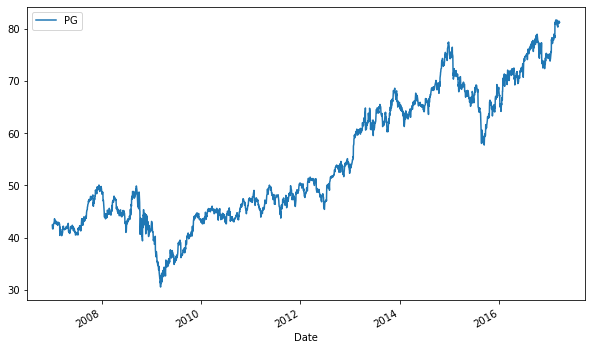

In [28]:
data.plot(figsize=(10, 6));

In [36]:
r = 0.025
T = 1.0 
stdev = log_returns.std() * 250 ** 0.5
stdev = stdev.values

In [37]:
t_intervals = 250 
delta_t = T / t_intervals  
iterations = 10000  

In [38]:
Z = np.random.standard_normal((t_intervals + 1, iterations))  
S = np.zeros_like(Z) 
S0 = data.iloc[-1]  
S[0] = S0 

In [39]:
for t in range(1, t_intervals + 1):
    S[t] = S[t-1] * np.exp((r - 0.5 * stdev ** 2) * delta_t + stdev * delta_t ** 0.5 * Z[t])

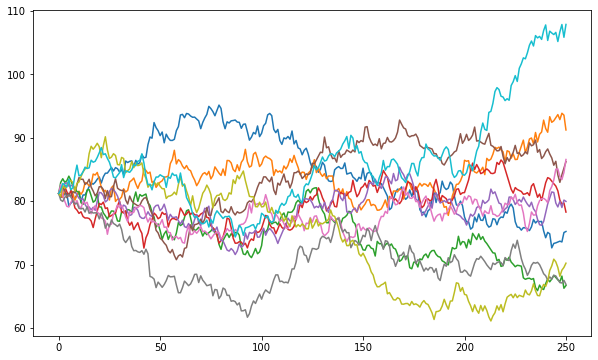

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(S[:, :10]);

In [41]:
#average discounted payoff
p = np.maximum(S[-1] - 110, 0)

In [42]:
C1 = np.exp(-r * T) * np.sum(p) / iterations
C1  

0.35295842478946277